In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ultimate-spotify-tracks-db/SpotifyFeatures.csv


The primary goal of the supervised learning classification project was to predict whether a song is popular or not popular based on its audio features. Specifically, the task involved:

Converting the song popularity score into binary classes:

Popular (popularity score ≥ 50).
Not Popular (popularity score < 50).
Training a classification model to determine whether a song will be classified as popular or not popular based on various features such as acousticness, danceability, energy, loudness, and other audio characteristics.

# Exploratory Data Analysis (EDA)

In [7]:
import pandas as pd

df = pd.read_csv('/kaggle/input/ultimate-spotify-tracks-db/SpotifyFeatures.csv')

df.head()

# check for missing values
print("Check for missing values \n", df.isnull().sum())

# drop rows with missing 'track_name'
df = df.dropna(subset=['track_name'])
print("Drop rows with missing 'track_name'\n", df.isnull().sum())

# filter songs with duration between 30 seconds (30000 ms) and 10 minutes (600000 ms)
df = df[(df['duration_ms'] > 30000) & (df['duration_ms'] < 600000)]

# remove tracks with loudness less than -40 dB
df = df[df['loudness'] > -40]

df.head()


Check for missing values 
 genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64
Drop rows with missing 'track_name'
 genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


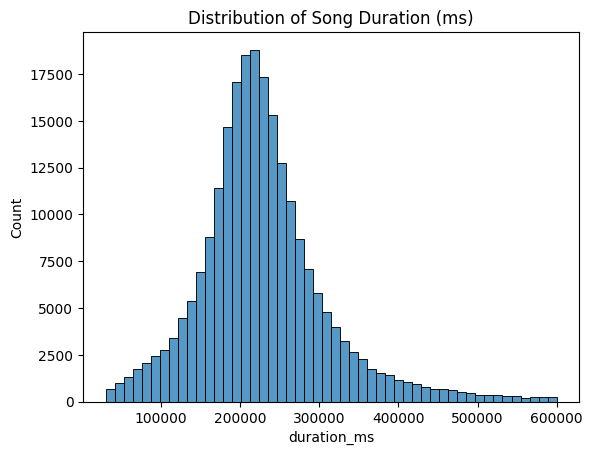

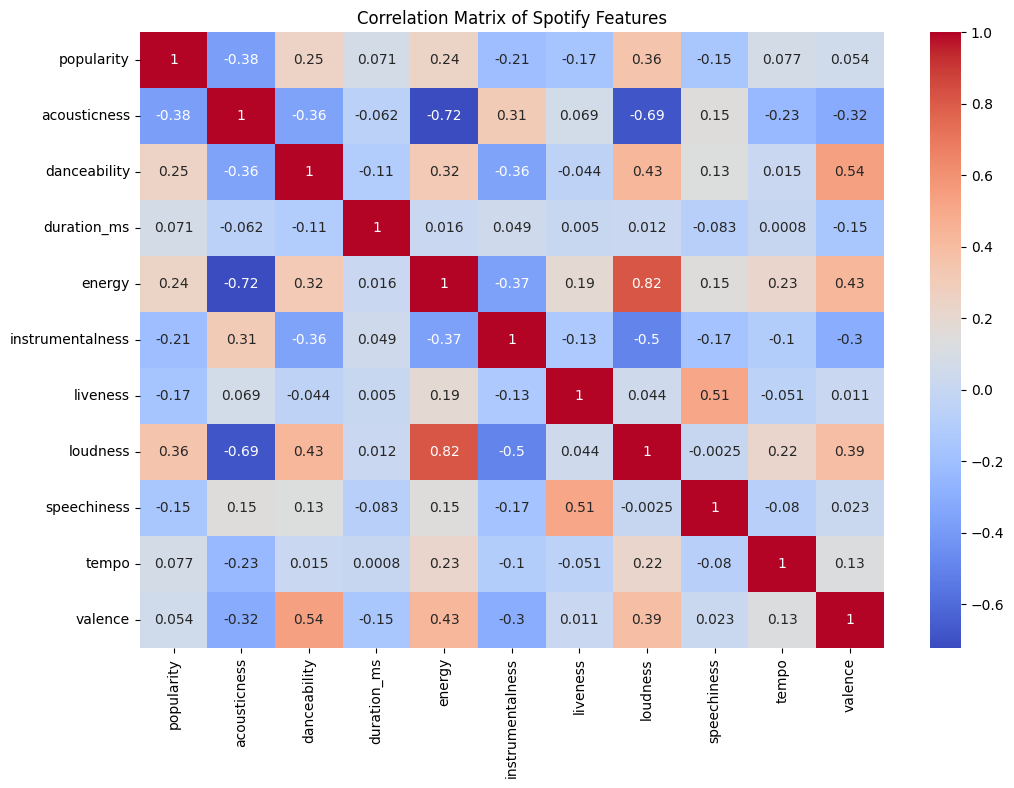

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


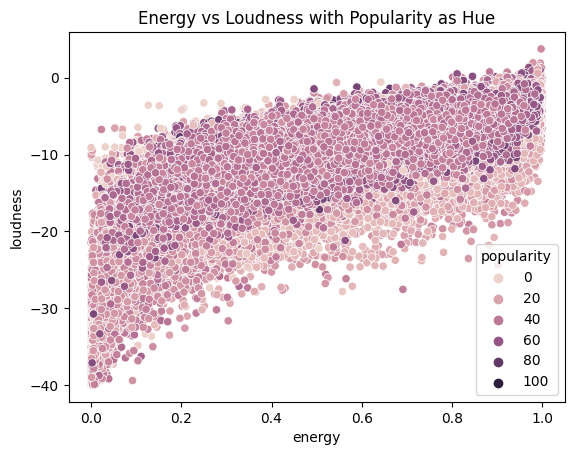

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


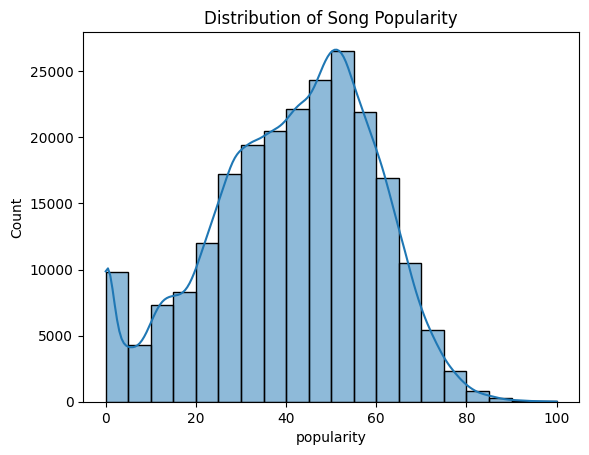

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# visualize the distribution of song duration
sns.histplot(df['duration_ms'], bins=50)
plt.title('Distribution of Song Duration (ms)')
plt.show()

# correlation matrix heatmap of numerical features
numerical_columns = ['popularity', 'acousticness', 'danceability', 'duration_ms', 
                     'energy', 'instrumentalness', 'liveness', 'loudness', 
                     'speechiness', 'tempo', 'valence']

plt.figure(figsize=(12,8))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Spotify Features')
plt.show()

# scatter plot to visualize relationship between energy and loudness
sns.scatterplot(x='energy', y='loudness', hue='popularity', data=df)
plt.title('Energy vs Loudness with Popularity as Hue')
plt.show()

# visualize the distribution of the popularity feature
sns.histplot(df['popularity'], bins=20, kde=True)
plt.title('Distribution of Song Popularity')
plt.show()

# Data Preprocessing

In [9]:
# convert categorical columns 'key', 'mode', and 'time_signature' to numerical codes
df['key'] = df['key'].astype('category').cat.codes
df['mode'] = df['mode'].map({'Major': 1, 'Minor': 0})
df['time_signature'] = df['time_signature'].astype('category').cat.codes

# scale the numerical features using StandardScaler
from sklearn.preprocessing import StandardScaler

#lList of numerical features to scale
numerical_features = ['acousticness', 'danceability', 'duration_ms', 'energy', 
                      'instrumentalness', 'liveness', 'loudness', 'speechiness', 
                      'tempo', 'valence', 'key', 'mode', 'time_signature']

scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features)

# add the 'popularity' column back
df_scaled['popularity'] = df['popularity']

In [10]:
from sklearn.model_selection import train_test_split

# features (X) and target (y) for supervised learning
X = df_scaled.drop(columns=['popularity'])
y = df_scaled['popularity']

# split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(184224, 13) (46057, 13) (184224,) (46057,)


In [25]:
print(f"NaN values in y_train: {y_train.isna().sum()}")

NaN values in y_train: 1957


In [29]:
# convert popularity into binary classes (1 = Popular, 0 = Not Popular)
df['popularity_class'] = np.where(df['popularity'] >= 50, 1, 0)

# add the 'popularity_class' column to the scaled dataframe
df_scaled['popularity_class'] = df['popularity_class']

# features (X) and target (y) for classification
X_class = df_scaled.drop(columns=['popularity', 'popularity_class'])  # Use same features as for regression
y_class = df_scaled['popularity_class']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)


In [31]:
# get indices where y_train_class is not NaN
non_null_train_indices = ~y_train_class.isna()

# get indices where y_test_class is not NaN
non_null_test_indices = ~y_test_class.isna()

# filter X and y based on non-null indices
X_train_class_clean = X_train_class[non_null_train_indices]
y_train_class_clean = y_train_class[non_null_train_indices]

X_test_class_clean = X_test_class[non_null_test_indices]
y_test_class_clean = y_test_class[non_null_test_indices]


# Algorithm Selection & Hyperparameter Optimization

> * Evaluated models for regression using cross-validation (Linear Regression, Random Forest, and Support Vector Regressor).
> * Selected Random Forest as the best model based on the lowest Mean CV MSE.
> * Used Random Forest for the classification task to predict whether a song is popular or not popular, and evaluated its performance.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# define the hyperparameter grid for Random Forest
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_distributions,
    n_iter=20,  # num of iterations for Randomized Search
    cv=3,       # 3 fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='accuracy'
)

# randomizedSearchCV on the classification training data
random_search.fit(X_train_class_clean, y_train_class_clean)

# get the best hyperparameters from the search
best_params = random_search.best_params_
print(f"Best hyperparameters for classification: {best_params}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  46.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 2.1min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.4min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.4min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.4min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  57.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 3.1min
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 2.1min
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time= 1.0min
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.0min
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.3min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  57.0s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 3.1min
[CV] END bootstrap=True, max_depth=None, min_samples_

**Best hyperparameters for classification:**
* n_estimators: 300, 
* min_samples_split: 2, 
* min_samples_leaf: 4, 
* max_depth: 30, 
* bootstrap: False

In [33]:
# train the best RandomForestClassifier model with optimal hyperparameters
best_model_classifier = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_depth=best_params['max_depth'],
    bootstrap=best_params['bootstrap'],
    random_state=42
)

# train the classifier on the full training set
best_model_classifier.fit(X_train_class_clean, y_train_class_clean)

# predict on the test set
y_pred_class = best_model_classifier.predict(X_test_class_clean)


# Model Evaluation

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train_class_clean, y_train_class_clean)

# predict on the cleaned test set
y_pred_class = rf_classifier.predict(X_test_class_clean)

# ensure y_test_class_clean and y_pred_class are consistent
print(f"y_test_class_clean size: {len(y_test_class_clean)}")
print(f"y_pred_class size: {len(y_pred_class)}")

accuracy = accuracy_score(y_test_class_clean, y_pred_class)
precision = precision_score(y_test_class_clean, y_pred_class)
recall = recall_score(y_test_class_clean, y_pred_class)
f1 = f1_score(y_test_class_clean, y_pred_class)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

conf_matrix = confusion_matrix(y_test_class_clean, y_pred_class)
print(f"Confusion Matrix:\n{conf_matrix}")


y_test_class_clean size: 45575
y_pred_class size: 45575
Accuracy: 0.7316
Precision: 0.6638
Recall: 0.5470
F1 Score: 0.5998
Confusion Matrix:
[[24179  4642]
 [ 7589  9165]]


The model correctly predicted the popularity status of songs 73.16% of the time, showing reasonable overall performance.

**Confusion Matrix Breakdown:**
* True Positives (TP): 9,165 — Popular songs correctly identified as popular.
* True Negatives (TN): 24,179 — Non-popular songs correctly identified as non-popular.
* False Positives (FP): 4,642 — Non-popular songs incorrectly identified as popular.
* False Negatives (FN): 7,589 — Popular songs incorrectly identified as non-popular.